In [253]:
"""
Coding up a transformer from scratch
"""

'\nCoding up a transformer from scratch\n'

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from tqdm import tqdm
import math
import re
from torch.utils.data import Dataset, DataLoader
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [2]:
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = f.read().splitlines()
    return data

train_en = load_data('train.en')
train_fr = load_data('train.fr')
test_en = load_data('test.en')
test_fr = load_data('test.fr')
dev_en = load_data('dev.en')
dev_fr = load_data('dev.fr')
train = list(zip(train_en, train_fr))
test = list(zip(test_en, test_fr))
dev = list(zip(dev_en, dev_fr))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32

In [3]:

# define the maximum sequence length
max_seq_length = 128

# define a function to preprocess the data
def preprocess_data(data):
    processed_data = []
    for sentence in data:
        # remove text within html tags
        sentence = sentence.lower()
        sentence = re.sub('<.*?>*<.*?>', '', sentence)
        if sentence == '' or sentence == ' ':
            continue
        if len(sentence) > max_seq_length:
            sentence = sentence[:max_seq_length]
        processed_data.append(sentence)
    return processed_data

train_en = preprocess_data(train_en)
train_fr = preprocess_data(train_fr)
test_en = preprocess_data(test_en)
test_fr = preprocess_data(test_fr)
dev_en = preprocess_data(dev_en)
dev_fr = preprocess_data(dev_fr)

In [4]:
train_data = list(zip(train_en, train_fr))
test_data = list(zip(test_en, test_fr))
dev_data = list(zip(dev_en, dev_fr))

In [5]:
from nltk.tokenize import word_tokenize

# define a function to tokenize the data
def tokenize_data(data, lang = 'english'):
    tokenized_data = []
    for sentence in data:
        if sentence == '' or sentence == ' ' or sentence == '\n':
            continue
        tokenized_data += word_tokenize(sentence, language = lang)
    return tokenized_data

train_tokens_en = tokenize_data(train_en)
train_tokens_fr = tokenize_data(train_fr, lang = 'french')
test_tokens_en = tokenize_data(test_en)
test_tokens_fr = tokenize_data(test_fr, lang = 'french')
dev_tokens_en = tokenize_data(dev_en)
dev_tokens_fr = tokenize_data(dev_fr, lang = 'french')

vocab_en = torchtext.vocab.build_vocab_from_iterator([train_tokens_en], min_freq=3, specials=['<unk>', '<pad>', '<start>', '<eos>'])
vocab_en.set_default_index(vocab_en['<unk>'])
vocab_fr = torchtext.vocab.build_vocab_from_iterator([train_tokens_fr], min_freq=3, specials=['<unk>', '<pad>', '<start>', '<eos>'])
vocab_fr.set_default_index(vocab_fr['<unk>'])

In [28]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.fc = nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]
        # print(f'query shape {query.shape}')
        # Linear transformations
        Q = self.query(query)
        K = self.key(key)
        V = self.value(value)
        # print(f'Q shape {Q.shape}, K shape {K.shape}, V shape {V.shape}...')
        
        # Reshape Q, K, V
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        
        # Compute scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)
        # print(f'Q shape {Q.shape}, K shape {K.shape}, V shape {V.shape}, scores shape {scores.shape} head_dim {self.head_dim}')
        # Apply mask
        if mask is not None:
            # print('scores', scores)
            scores = scores.masked_fill(mask != 0, -1e9)
            # print('scores after masking', scores)
        # print('mask', mask)
        # print('scores', scores)
        # Softmax
        scaling_factor = torch.tensor(scores.shape[-1]).float().sqrt()
        attention = torch.softmax(scores / scaling_factor, dim=-1)
        # print('attention', attention)
        
        # Compute weighted sum
        weighted_sum = torch.matmul(attention, V)
        
        # Reshape and apply final linear transformation
        weighted_sum = weighted_sum.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.fc(weighted_sum)
        
        return output.to(device)

class Transformer(nn.Module):
    def __init__(self, input_size, output_size, d_model=512, nhead=8, num_layers=2):
        super(Transformer, self).__init__()
        self.encoder = nn.ModuleList([EncoderLayer(d_model, nhead).to(device) for _ in range(num_layers)])
        self.decoder = nn.ModuleList([DecoderLayer(d_model, nhead).to(device) for _ in range(num_layers)])
        self.fc = nn.Linear(d_model, output_size).to(device)
        self.src_embed = nn.Embedding(input_size, d_model).to(device)
        self.tgt_embed = nn.Embedding(output_size, d_model).to(device)
        self.pos_encoder = PositionalEncoding(d_model).to(device)
        self.pos_decoder = PositionalEncoding(d_model).to(device)
        self.d_model = d_model

    def forward(self, src, tgt):
        # src_mask = self.generate_square_subsequent_mask(src.size(0)).to(device)
        tgt_mask = self.generate_square_subsequent_mask(tgt).to(device)
        src = self.src_embed(src) * torch.sqrt(torch.tensor(self.d_model).float())
        # print('src', src)
        tgt = self.tgt_embed(tgt) * torch.sqrt(torch.tensor(self.d_model).float())
        # print('tgt', tgt)
        src = self.pos_encoder(src)
        # print('src_pos', src)
        tgt = self.pos_decoder(tgt)
        # print('tgt_pos', tgt)
        for layer in self.encoder:
            src = layer(src) # src_mask
        # print('src enc', src)
        for layer in self.decoder:
            tgt = layer(tgt, src, tgt_mask)
        # print('tgt dec', tgt)
        output = self.fc(tgt)
        return output.to(device)

    def generate_square_subsequent_mask(self, tgt):
        sz = tgt.size(1)
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1).to(device)
        tgt_mask = mask.float().masked_fill_(mask == 0, -1e9).masked_fill_(mask == 1, float(0.0)).to(device)
        # print(f'mask shape {mask.shape}')
        # tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        # seq_length = tgt.size(1)
        # nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to(device)
        # tgt_mask = tgt_mask & nopeak_mask
        return tgt_mask.to(device)

class EncoderLayer(nn.Module):
    def __init__(self, d_model, nhead):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, nhead).to(device)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, 2048).to(device),
            nn.ReLU(),
            nn.Linear(2048, d_model).to(device)
        )
        self.norm1 = nn.LayerNorm(d_model).to(device)
        self.norm2 = nn.LayerNorm(d_model).to(device)

    def forward(self, src, src_mask=None):
        src2 = self.self_attn(src, src, src, mask=src_mask)
        src = src + src2
        src = self.norm1(src)
        src2 = self.feed_forward(src)
        src = src + src2
        src = self.norm2(src)
        return src.to(device)

class DecoderLayer(nn.Module):
    def __init__(self, d_model, nhead):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, nhead).to(device)
        self.src_attn = MultiHeadAttention(d_model, nhead).to(device)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, 2048).to(device),
            nn.ReLU(),
            nn.Linear(2048, d_model).to(device)
        )
        self.norm1 = nn.LayerNorm(d_model).to(device)
        self.norm2 = nn.LayerNorm(d_model).to(device)
        self.norm3 = nn.LayerNorm(d_model).to(device)

    def forward(self, tgt, src, tgt_mask, src_mask=None):
        tgt2 = self.self_attn(tgt, tgt, tgt, mask=tgt_mask)
        # print('tgt after self attn', tgt)
        tgt = tgt + tgt2
        tgt = self.norm1(tgt)
        tgt2 = self.src_attn(tgt, src, src, mask=src_mask)
        tgt = tgt + tgt2
        tgt = self.norm2(tgt)
        tgt2 = self.feed_forward(tgt)
        tgt = tgt + tgt2
        tgt = self.norm3(tgt)
        return tgt.to(device)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model).to(device)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1).to(device)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)).to(device)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x).to(device)


In [25]:
class Dataset(Dataset):
    def __init__(self, data, vocab_en, vocab_fr):
        self.data = data
        self.vocab_en = vocab_en
        self.vocab_fr = vocab_fr

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        en, fr = self.data[idx]
        en = [self.vocab_en[token] for token in tokenize_data([en])] + [self.vocab_en['<eos>']]
        fr = [self.vocab_fr['<start>']] + [self.vocab_fr[token] for token in tokenize_data([fr], lang='french')] + [self.vocab_fr['<eos>']]
        # print(en)
        return torch.tensor(en), torch.tensor(fr)
    
    def collate_fn(self, batch):
        en, fr = zip(*batch)
        max_input_len = max([len(sentence) for sentence in en])
        max_output_len = max([len(sentence) for sentence in fr])
        max_len = max(max_input_len, max_output_len)
        # print(f'max_len {max_len}')
        en = [sentence.tolist() + [self.vocab_en['<pad>']] * (max_len - len(sentence)) for sentence in en]
        fr = [sentence.tolist() + [self.vocab_fr['<pad>']] * (max_len - len(sentence)) for sentence in fr]
        return torch.tensor(en), torch.tensor(fr)

In [26]:
train_dataset = Dataset(train_data, vocab_en, vocab_fr)
test_dataset = Dataset(test_data, vocab_en, vocab_fr)
dev_dataset = Dataset(dev_data, vocab_en, vocab_fr)

In [27]:
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=train_dataset.collate_fn)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=test_dataset.collate_fn)
dev_dl = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=dev_dataset.collate_fn)

In [29]:
# define the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model = Transformer(input_size=len(vocab_en), output_size=len(vocab_fr))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 5
model = model.to(device)

In [30]:
def train_epoch(model, dl):
    model.train()
    total_loss = 0; i = 1
    for en, fr in tqdm(dl):
        en = en.to(device)
        fr = fr.to(device)
        optimizer.zero_grad()
        output = model(en, fr[:, :-1])
        output = output.transpose(1, 2)
        # print(output)
        loss = loss_fn(output, fr[:, 1:])
        # print(f'Batch {i} loss {loss.item()}')
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dl)

def evaluate(model, dl):
    model.eval()
    total_loss = 0
    for en, fr in tqdm(dl):
        en = en.to(device)
        fr = fr.to(device)
        output = model(en, fr[:, :-1])
        output = output.transpose(1, 2)
        loss = loss_fn(output, fr[:, 1:])
        total_loss += loss.item()
    return total_loss / len(dl)

def train(model, loss_fn, optimizer, dl, epochs):
    model.optim = optimizer
    model.loss_fn = loss_fn
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}', end=' ')
        loss = train_epoch(model, dl)
        print(f'Train loss: {loss:.4f}')
        loss = evaluate(model, dl)
        print(f'Validation loss: {loss:.4f}')

In [31]:
train(model, loss_fn, optimizer, train_dl, epochs)

Epoch 1/5 

100%|██████████| 877/877 [04:00<00:00,  3.64it/s]


Train loss: 2.7111


  5%|▌         | 46/877 [00:04<01:24,  9.83it/s]


KeyboardInterrupt: 

In [10]:
idx2word_en = vocab_en.get_itos()
idx2word_fr = vocab_fr.get_itos()

In [13]:
# save model
# torch.save(model.state_dict(), 'model.pt')

In [ ]:
# loaded_model = Transformer(input_size=len(vocab_en), output_size=len(vocab_fr))
# loaded_model.load_state_dict(torch.load('model.pt'))
# loaded_model.eval()
# with torch.no_grad():
#     for en, fr in dev_dl:
#         en = en.to(device)
#         fr = fr.to(device)
#         output = loaded_model(en, fr[:, :-1])
#         output = output.transpose(1, 2)
#         # print(output)
#         loss = loss_fn(output, fr[:, 1:])
#         print(f'Loss: {loss.item()}')
        

In [117]:
model.eval()
total_loss = 0; i = 1
predictions = []; targets = []; bleu_scores = []; en_sentences = []
with torch.no_grad():
    for en, fr in tqdm(test_dl):
        en = en.to(device)
        fr = fr.to(device)
        output = model(en, fr[:, :-1])
        output = output.transpose(1, 2)
        loss = loss_fn(output, fr[:, 1:])
        total_loss += loss.item()
        i += 1
        output = output.argmax(dim=1)
        # print(output)
        # convert output to words
        for i, sentence in enumerate(output):
            tgt = fr[i]
            tgt = [idx2word_fr[word.item()] for word in tgt[1:]]
            tgt = ' '.join(tgt).split('<pad>')[0]
            targets.append(word_tokenize(tgt))
            # print('target: ', targets[-1])
            en_sentence = en[i]
            en_sentence = [idx2word_en[word.item()] for word in en_sentence]
            en_sentence = ' '.join(en_sentence).split('<pad>')[0]
            en_sentences.append(word_tokenize(en_sentence))
            sentence = [idx2word_fr[word.item()] for word in sentence]
            sentence = ' '.join(sentence).split('<pad>')[0]
            predictions.append(word_tokenize(sentence))
            bleu = sentence_bleu([targets[-1]], predictions[-1], smoothing_function=SmoothingFunction().method4)
            # print(f'BLEU score: {bleu}')
            bleu_scores.append(bleu)
            # print('prediction: ', predictions[-1])
            # break
        # break
print(f'Test loss: {total_loss / len(test_dl):.4f}')

100%|██████████| 40/40 [00:05<00:00,  7.20it/s]

Test loss: 2.3193


In [109]:
from torchtext.data.metrics import bleu_score
a = ['The', 'cat', 'sat', 'on', 'the', 'mat']
b = ['The', 'cat', 'sat', 'on', 'the', 'tat']
print(bleu_score([a], [[b]]))
print(sentence_bleu([b], a))

0.7598356604576111
0.7598356856515925


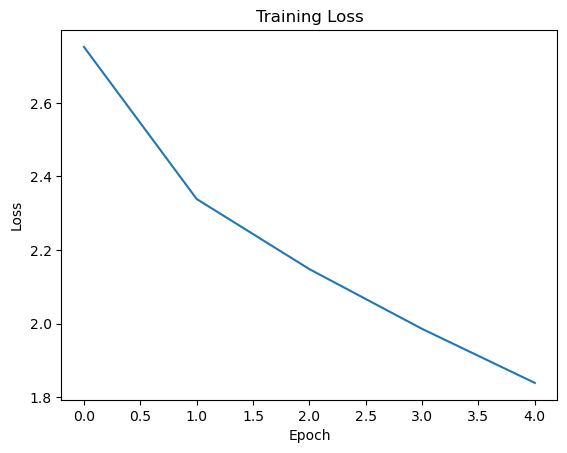

In [107]:
initial_training_losses = [2.7523, 2.3388, 2.1481, 1.9856, 1.8387]
# plot the training loss
import matplotlib.pyplot as plt
plt.plot(initial_training_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [108]:
# find index with max bleu score
max_bleu = max(bleu_scores)
i = bleu_scores.index(max_bleu)
bleu_scores[i]
print(targets[i])
print(predictions[i])

['merci', '.', '<', 'eos', '>']
['merci', '.', '<', 'eos', '>']


In [118]:
# write the predictions, targets, and bleu scores to a file
with open('test_bleu.txt', 'w') as f:
    for i in range(len(predictions)):
        pred = ' '.join(predictions[i])
        tgt = ' '.join(en_sentences[i])
        f.write(f'Sentence: {tgt}\n')
        f.write(f'Prediction: {pred}\n')
        f.write(f'BLEU score: {bleu_scores[i]}\n\n')

In [119]:
model.eval()
i = 1
predictions = []; targets = []; bleu_scores = []; en_sentences = []
with torch.no_grad():
    for en, fr in tqdm(train_dl):
        en = en.to(device)
        fr = fr.to(device)
        output = model(en, fr[:, :-1])
        output = output.transpose(1, 2)
        i += 1
        output = output.argmax(dim=1)
        for i, sentence in enumerate(output):
            tgt = fr[i]
            tgt = [idx2word_fr[word.item()] for word in tgt[1:]]
            tgt = ' '.join(tgt).split('<pad>')[0]
            targets.append(word_tokenize(tgt))
            en_sentence = en[i]
            en_sentence = [idx2word_en[word.item()] for word in en_sentence]
            en_sentence = ' '.join(en_sentence).split('<pad>')[0]
            en_sentences.append(word_tokenize(en_sentence))
            sentence = [idx2word_fr[word.item()] for word in sentence]
            sentence = ' '.join(sentence).split('<pad>')[0]
            predictions.append(word_tokenize(sentence))
            bleu = sentence_bleu([targets[-1]], predictions[-1], smoothing_function=SmoothingFunction().method4)
            bleu_scores.append(bleu)

with open('train_bleu.txt', 'w') as f:
    for i in range(len(predictions)):
        pred = ' '.join(predictions[i])
        tgt = ' '.join(en_sentences[i])
        f.write(f'Sentence: {tgt}\n')
        f.write(f'Prediction: {pred}\n')
        f.write(f'BLEU score: {bleu_scores[i]}\n\n')

100%|██████████| 877/877 [02:00<00:00,  7.27it/s]


In [19]:
### Hyperparameter Tuning ###
# define the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
loss_fn = nn.CrossEntropyLoss()
lrs = [0.01, 0.001, 0.0001]
epochs = 2

def train_epoch(model, dl, optimizer):
    model.train()
    total_loss = 0; i = 1
    for en, fr in tqdm(dl):
        en = en.to(device)
        fr = fr.to(device)
        optimizer.zero_grad()
        output = model(en, fr[:, :-1])
        output = output.transpose(1, 2)
        # print(output)
        loss = loss_fn(output, fr[:, 1:])
        # print(f'Batch {i} loss {loss.item()}')
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dl)

def evaluate(model, dl):
    model.eval()
    total_loss = 0
    for en, fr in tqdm(dl):
        en = en.to(device)
        fr = fr.to(device)
        output = model(en, fr[:, :-1])
        output = output.transpose(1, 2)
        loss = loss_fn(output, fr[:, 1:])
        total_loss += loss.item()
    return total_loss / len(dl)

train_losses = {0.01:[],0.001:[],0.0001:[]}; val_losses = {0.01:[],0.001:[],0.0001:[]}
for lr in lrs:
    print(f'Learning rate: {lr}')
    model = Transformer(input_size=len(vocab_en), output_size=len(vocab_fr))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model = model.to(device)
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}', end=' ')
        train_loss = train_epoch(model, train_dl, optimizer)
        print(f'Train loss: {train_loss:.4f}')
        val_loss = evaluate(model, dev_dl)
        print(f'Validation loss: {val_loss:.4f}')
        train_losses[lr].append(train_loss)
        val_losses[lr].append(val_loss)

Learning rate: 0.01
Epoch 1/2 

100%|██████████| 877/877 [04:05<00:00,  3.57it/s]


Train loss: 4.2987


100%|██████████| 27/27 [00:02<00:00, 10.07it/s]


Validation loss: 4.1568
Epoch 2/2 

100%|██████████| 877/877 [04:07<00:00,  3.54it/s]


Train loss: 4.1964


100%|██████████| 27/27 [00:02<00:00, 10.06it/s]


Validation loss: 4.1486
Learning rate: 0.001
Epoch 1/2 

100%|██████████| 877/877 [04:06<00:00,  3.55it/s]


Train loss: 2.7195


100%|██████████| 27/27 [00:02<00:00, 10.04it/s]


Validation loss: 2.4879
Epoch 2/2 

100%|██████████| 877/877 [04:07<00:00,  3.55it/s]


Train loss: 2.2674


100%|██████████| 27/27 [00:02<00:00, 10.04it/s]


Validation loss: 2.3775
Learning rate: 0.0001
Epoch 1/2 

100%|██████████| 877/877 [04:06<00:00,  3.56it/s]


Train loss: 3.0125


100%|██████████| 27/27 [00:02<00:00,  9.92it/s]


Validation loss: 2.6692
Epoch 2/2 

100%|██████████| 877/877 [04:05<00:00,  3.57it/s]


Train loss: 2.4723


100%|██████████| 27/27 [00:02<00:00, 10.01it/s]

Validation loss: 2.4690


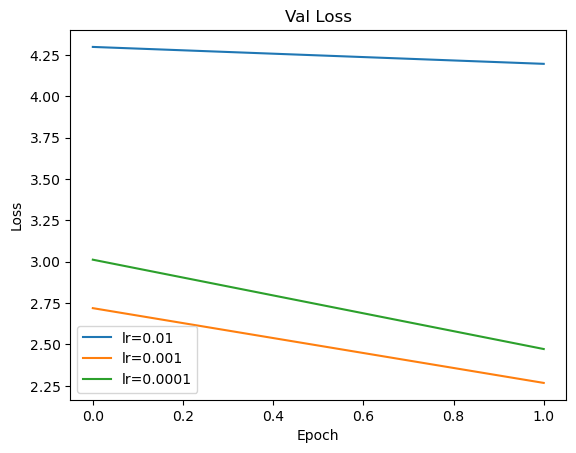

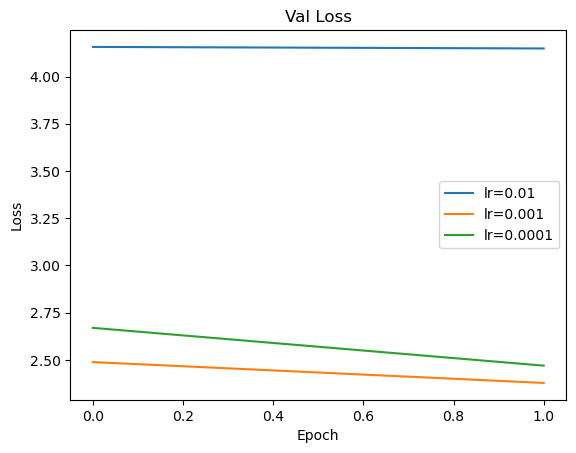

In [23]:
# write a function to take a list of losses and plot it
import matplotlib.pyplot as plt
def plot_losses(losses, lrs):
    for lr in lrs:
        plt.plot(losses[lr], label=f'lr={lr}')
    plt.title('Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


plot_losses(train_losses, lrs)
plot_losses(val_losses, lrs)